In [1]:
!pip install python-igraph

     |████████████████████████████████| 3.1MB 2.8MB/s 


In [2]:
!git clone https://github.com/pranavkulkarni/Link_prediction_social_network.git

Cloning into 'Link_prediction_social_network'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), done.


In [0]:
from igraph import *
from math import *
import sys
import numpy as np
import os
import glob
import random
from random import shuffle
from random import seed
import matplotlib.pyplot as plt
import time
import datetime
import collections

In [0]:
# Constants
k = 5 		# Top k recomendations for a target user (Used for testing model-accuracy metrics)
maxl = 2 	# Number of iterations for Katz Algorithm (beta^maxl ~ 0)
beta = 0.1 	# The damping factor for Katz Algorithm

preli = []
reli = []

In [0]:
# load edge-list from file
def get_edge_list(dataset_path):
	data_file = open(dataset_path)
	edge_list = map(lambda x:tuple(map(int,x.split())),data_file.read().split("\n")[:-1])
	data_file.close()
	return edge_list

In [0]:
# Get the similarity product for a path
# (product of path-step similarities)
def get_sim_product(sim, shortest_path):
	prod = 1
	for i in range(len(shortest_path) - 1):
		prod *= sim[shortest_path[i]][shortest_path[i+1]]
	return round(prod,3)

In [0]:
# Filter out, Sort and Get top-K predictions
def get_top_k_recommendations(graph,sim,i,k):
	return  sorted(filter(lambda x: i!=x and graph[i,x] != 1,range(len(sim[i]))) , key=lambda x: sim[i][x],reverse=True)[0:k]


In [0]:
# Convert edge_list into a set of constituent edges
def get_vertices_set(edge_list):
	res = set()
	for x,y in edge_list:
		res.add(x)
		res.add(y)
	return res

In [0]:
# Split the dataset into two parts (50-50 split)
# Create 2 graphs, 1 used for training and the other for testing
def split_data(edge_list):
	random.seed(350)
	indexes = range(len(edge_list))
	test_indexes = set(random.sample(indexes, int(len(indexes)/4))) # removing 50% edges from test data
	train_indexes = set(indexes).difference(test_indexes)
	test_list = [edge_list[i] for i in test_indexes]
	print("Len of test data ",len(test_list))
	train_list = [edge_list[i] for i in train_indexes]
	print("Len of train data ",len(train_list))
	return train_list,test_list

In [0]:
# Calculates accuracy metrics (Precision & Recall),
# for a given similarity-model against a test-graph.

def print_precision_and_recall(sim,train_graph,test_graph,test_vertices_set,train_vertices_set):
	precision = recall = c = 0
	for i in test_vertices_set:
		if i in train_vertices_set:
			actual_friends_of_i = set(test_graph.neighbors(i))

			# Handles case where test-data < k
			if len(actual_friends_of_i) < k:
				k2 = len(actual_friends_of_i)
			else:
				k2 = k

			top_k = set(get_top_k_recommendations(train_graph,sim,i,k2))

			precision += len(top_k.intersection(actual_friends_of_i))/float(k2)
			recall += len(top_k.intersection(actual_friends_of_i))/float(len(actual_friends_of_i))
			c += 1
	# print("type pre = ", type(precision)," c = ",type(c)," recall = ",type(recall))
	preli.append(precision/c)
	reli.append(recall/c)
	print ("Precision is : " + str(precision/c))
	print ("Recall is : " + str(recall/c))


In [0]:
# http://be.amazd.com/link-prediction/
def similarity(graph, i, j, method):
	if method == "common_neighbors":
		return len(set(graph.neighbors(i)).intersection(set(graph.neighbors(j))))
	elif method == "jaccard":
		return len(set(graph.neighbors(i)).intersection(set(graph.neighbors(j))))/float(len(set(graph.neighbors(i)).union(set(graph.neighbors(j)))))
	elif method == "adamic_adar":
		return sum([1.0/math.log(graph.degree(v)) for v in set(graph.neighbors(i)).intersection(set(graph.neighbors(j)))])
	elif method == "preferential_attachment":
		return graph.degree(i) * graph.degree(j)
	elif method == "friendtns":
		return round((1.0/(graph.degree(i) + graph.degree(j) - 1.0)),3)

###################################
### Methods for Link Prediction ###
###################################

In [0]:
def local_methods(edge_list,method):
	train_list, test_list = split_data(edge_list)
	st, test_list = split_data(edge_list)
	train_graph = Graph(train_list)
	test_graph = Graph(test_list)
	train_n =  train_graph.vcount() # This is maximum of the vertex id + 1
	train_vertices_set = get_vertices_set(train_list) # Need this because we have to only consider target users who are present in this train_vertices_set
	test_vertices_set = get_vertices_set(test_list) # Set of target users

	sim = [[0 for i in range(train_n)] for j in range(train_n)]
	for i in range(train_n):
		for j in range(train_n):
			if i!=j and i in train_vertices_set and j in train_vertices_set:
				sim[i][j] = similarity(train_graph,i,j,method)

	print_precision_and_recall(sim,train_graph,test_graph,test_vertices_set,train_vertices_set)

In [0]:
# Calculates the Katz Similarity measure for a node pair (i,j)
def katz_similarity(katzDict,i,j):
	l = 1
	neighbors = katzDict[i]
	score = 0

	while l <= maxl:
		numberOfPaths = neighbors.count(j)
		if numberOfPaths > 0:
			score += (beta**l)*numberOfPaths

		neighborsForNextLoop = []
		for k in neighbors:
			neighborsForNextLoop += katzDict[k]
		neighbors = neighborsForNextLoop
		l += 1

	return score


In [0]:
# Implementation of the Katz algorithm
def katz(edge_list):
	train_list, test_list = split_data(edge_list)
	train_graph = Graph(train_list)
	test_graph = Graph(test_list)
	train_n = train_graph.vcount()
	train_vertices_set = get_vertices_set(train_list) # Need this because we have to only consider target users who are present in this train_vertices_set
	test_vertices_set = get_vertices_set(test_list) # Set of target users

	# build a special dict that is like an adjacency list
	katzDict = {}
	adjList = train_graph.get_adjlist()

	for i, l in enumerate(adjList):
		katzDict[i] = l

	sim = [[0 for i in xrange(train_n)] for j in xrange(train_n)]
	for i in xrange(train_n):
		print (i)
         
		if i not in train_vertices_set:
			continue

		for j in xrange(i+1, train_n):
			if j in train_vertices_set:		# TODO: check if we need this
				sim[i][j] = sim[j][i] = katz_similarity(katzDict,i,j)

	print_precision_and_recall(sim,train_graph,test_graph,test_vertices_set,train_vertices_set)

In [0]:
# Implementation of the friendTNS algorithm
def friendtns(edge_list, method):
	train_list, test_list = split_data(edge_list)
	train_graph = Graph(train_list)
	test_graph = Graph(test_list)
	train_n =  train_graph.vcount() # This is maximum of the vertex id + 1
	train_vertices_set = get_vertices_set(train_list) # Need this because we have to only consider target users who are present in this train_vertices_set
	test_vertices_set = get_vertices_set(test_list) # Set of target users

	sim = [[0 for i in range(train_n)] for j in range(train_n)]
	for i in range(train_n):
		for j in range(train_n):
			if i!=j and i in train_vertices_set and j in train_vertices_set and train_graph[i,j] != 0:
				sim[i][j] = similarity(train_graph,i,j,method)


	# Calculate Shortest Paths from each vertex to every other vertex in the train_vertices_set
	sp = {}
	for i in train_vertices_set:
		sp[i] = train_graph.get_shortest_paths(i)

	# Extended Sim matrix
	esim = [[0 for i in range(train_n)] for j in range(train_n)]
	for i in range(train_n):
		for j in range(train_n):
			if i!=j and i in train_vertices_set and j in train_vertices_set:
				if len(sp[i][j]) == 0: # no path exists
					esim[i][j] = 0
				elif train_graph[i,j] == 1 and train_graph[j,i] == 1: # are neighbors
					esim[i][j] = sim[i][j]
				else:
					esim[i][j] = get_sim_product(sim,sp[i][j])

	print_precision_and_recall(esim,train_graph,test_graph,test_vertices_set,train_vertices_set)


In [0]:
def main():
	# default-case/ help
	if len(sys.argv) < 3 :
		print ("python link_prediction.py <common_neighbors/jaccard/adamic_adar/preferential_attachment/katz/friendtns> data_file_path")
		exit(1)

	# Command line argument parsing
	# method = "adamic_adar"
	dataset_path = "/content/Link_prediction_social_network/data/facebook_combined.txt"
	edge_list = get_edge_list(dataset_path)
 
	method = "common_neighbors"
	local_methods(edge_list,method)
 
	method = "jaccard"
	local_methods(edge_list,method)

	method = "adamic_adar"
	local_methods(edge_list,method)
 
	method = "preferential_attachment"
	local_methods(edge_list,method)
 
	# if method == "common_neighbors" or method == "jaccard" or method == "adamic_adar" or method == "preferential_attachment":
	# 	local_methods(edge_list,method)
	# elif method == "katz":
	# 	katz(edge_list)
	# elif method == "friendtns":
	# 	friendtns(edge_list,method)
	# else:
	# 	print ("python link_prediction.py <common_neighbors/jaccard/adamic_adar/preferential_attachment/katz/friendtns> data_file_path")
	
	print("preli = ",preli)
	print("reli = ",reli)
 

In [28]:
main()

('Len of test data ', 22058)
('Len of train data ', 66176)
('Len of test data ', 22058)
('Len of train data ', 66176)
Precision is : 0.533048964721
Recall is : 0.291877044022
('Len of test data ', 22058)
('Len of train data ', 66176)
('Len of test data ', 22058)
('Len of train data ', 66176)
Precision is : 0.471074380165
Recall is : 0.243647761369
('Len of test data ', 22058)
('Len of train data ', 66176)
('Len of test data ', 22058)
('Len of train data ', 66176)
Precision is : 0.55199058029
Recall is : 0.30656862339
('Len of test data ', 22058)
('Len of train data ', 66176)
('Len of test data ', 22058)
('Len of train data ', 66176)
Precision is : 0.0497511774638
Recall is : 0.0283694963578
('preli = ', [0.5330489647205163, 0.4710743801652875, 0.5519905802896975, 0.04975117746378716])
('reli = ', [0.2918770440223591, 0.2436477613686059, 0.3065686233898653, 0.028369496357833042])


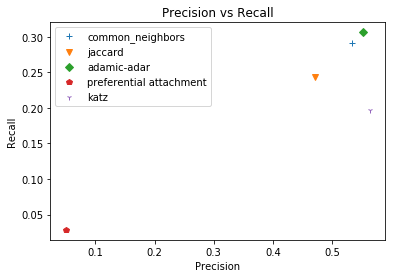

In [29]:
import matplotlib.pyplot as plt
preli.append(0.564150047483)
reli.append(0.197423074093)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision vs Recall")
plt.plot(preli[0],reli[0],'+',label = "common_neighbors")
plt.plot(preli[1],reli[1],'v',label = "jaccard")
plt.plot(preli[2],reli[2],'D',label = "adamic-adar")
plt.plot(preli[3],reli[3],'p',label = "preferential attachment")
plt.plot(preli[4],reli[4],'1',label = "katz")
plt.legend()
plt.show()